# ResNet

In [1]:
# please upload data directory to Google drive
# use Google Drive to load data
from google.colab import drive, files
import zipfile

drive.mount('/content/drive')
filename = 'requirements.txt'
uploaded = files.upload()

Mounted at /content/drive


Saving requirements.txt to requirements.txt


In [2]:
!pip install -r "./requirements.txt"
!pip install torchinfo
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.6/85.6 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 44.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.9/171.9 kB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.4/346.4 kB 34.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.0/812.0 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 74.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

In [14]:
from torch.nn import (Module, Sequential, Conv2d, BatchNorm2d, ReLU, MaxPool2d,
                      Linear, AdaptiveAvgPool2d, BatchNorm1d, Sigmoid, Dropout)
import torch
from sklearn.model_selection import train_test_split
import os
import librosa
import numpy as np
from torchinfo import summary
from torch import nn
from torch.optim import Adam
from torcheval.metrics import MulticlassAUROC, MulticlassF1Score
from torch.utils.data import Dataset, DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Add Methods

In [4]:
# Util
def create_dataloader(x, y, batch_size=64):
    x = torch.tensor(x, dtype=torch.float).cuda()
    y = torch.tensor(y, dtype=torch.long).cuda()
    data = TensorDataset(x, y)
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=True)
    return dataloader


def k_fold_cross_validation(x, y, k):
    fold_size = x.shape[0] // k
    xs_train = []
    ys_train = []
    xs_valid = []
    ys_valid = []
    for i in range(k - 1):
        xs_valid.append(x[fold_size * i:fold_size * (i + 1)])
        ys_valid.append(y[fold_size * i:fold_size * (i + 1)])
        xs_train.append(np.concatenate([x[:fold_size * i], x[fold_size * (i + 1):]], axis=0))
        ys_train.append(np.concatenate([y[:fold_size * i], y[fold_size * (i + 1):]], axis=0))
    xs_valid.append(x[fold_size * (k - 1):])
    ys_valid.append(y[fold_size * (k - 1):])
    xs_train.append(x[:fold_size * (k - 1)])
    ys_train.append(y[:fold_size * (k - 1)])
    return xs_train, ys_train, xs_valid, ys_valid

def train(model, loss_function, opt, dataloaders_train, dataloaders_valid, k, epoch=10):
    epochs_loss = []
    epochs_accuracy = []
    for i in range(epoch):
        print("-------epoch  {} -------".format(i + 1))
        epoch_loss = 0
        epoch_accuracy = 0

        for j in range(k):
            print(f'fold {j + 1}:')

            # train
            loss_train = 0
            accuracy_train = 0
            train_size = 0
            for batch_idx, (data, target) in enumerate(dataloaders_train[j]):
                data = data.cuda()
                target = target.cuda()
                model.train()
                output = model(data)
                loss = loss_function(output, target)
                opt.zero_grad()
                loss.backward()
                opt.step()
                data_size = len(data)
                loss_train += loss.item() * data_size
                accuracy_train += (output.argmax(1) == target).sum()
                train_size += data_size
            print("train set loss: {}".format(loss_train / train_size))
            print("train set accuracy: {}".format(accuracy_train / train_size))

            # valid
            loss_valid = 0
            accuracy_valid = 0
            valid_size = 0
            for batch_idx, (data, target) in enumerate(dataloaders_valid[j]):
                data = data.cuda()
                target = target.cuda()
                model.eval()
                with torch.no_grad():
                    output = model(data)
                    loss = loss_function(output, target)
                    data_size = len(data)
                    loss_valid += loss.item() * data_size
                    accuracy_valid += (output.argmax(1) == target).sum()
                    valid_size += data_size
            print("valid set loss: {}".format(loss_valid / valid_size))
            print("valid set accuracy: {}".format(accuracy_valid / valid_size))
            epoch_loss += loss_valid / valid_size
            epoch_accuracy += accuracy_valid / valid_size
        epoch_loss = round(epoch_loss / k, 3)
        epoch_accuracy = round(float(epoch_accuracy) / k, 3)
        print(f"epoch loss: {epoch_loss}")
        print(f"epoch accuracy: {epoch_accuracy}")
        epochs_loss.append(epoch_loss)
        epochs_accuracy.append(epoch_accuracy)
    return {"loss": epochs_loss, "accuracy": epochs_accuracy}


def test(model, loss_function, dataloader_test):
    loss_test = 0
    accuracy_test = 0
    AUC_test = 0
    f1_score_test = 0
    test_size = 0
    for batch_idx, (data, target) in enumerate(dataloader_test):
        data = data.cuda()
        target = target.cuda()
        model.eval()
        with torch.no_grad():
            output = model(data)
            loss = loss_function(output, target)
            loss_test += loss.item() * len(data)
            accuracy_test += (output.argmax(1) == target).sum()
            test_size += len(data)
            auc = MulticlassAUROC(num_classes=10)
            auc.update(output, target)
            AUC_test += auc.compute() * len(data)
            auc.reset()
            f1 = MulticlassF1Score(num_classes=10)
            f1.update(output, target)
            f1_score_test += f1.compute() * len(data)
            f1.reset()
    loss = round(loss_test / test_size, 3)
    accuracy = round(float(accuracy_test) / test_size,3)
    AUC = round(float(AUC_test) / test_size, 3)
    f1 = round(float(f1_score_test) / test_size,3)
    print(f"test set loss: {loss}")
    print(f"test set accuracy: {accuracy}")
    print(f"test set AUC: {AUC}")
    print(f"test set f1-score: {f1}")
    return loss, accuracy, AUC, f1

# Read Data

In [5]:
root = '/content/drive/MyDrive/why/genres_original' # Change according path storing data
genres = os.listdir(root)
x = []
y = []
length = []
sr = 16*1000
for genre in genres:
    genre_root = os.path.join(root, genre)
    audios = os.listdir(genre_root)
    for audio in audios:
        audio_path = os.path.join(genre_root, audio)
        signal, sr = librosa.load(audio_path, sr=sr)
        x.append(signal)
        length.append(len(signal))
        y.append(genres.index(genre))
min_length = min(length)
print("Finsh reading data")

Finsh reading data


# Segment and Normalise

In [6]:
# for i in range(len(x)):
#     x[i] = x[i][0:min_length]
#     x[i] = librosa.util.normalize(x[i])
# x = np.asarray(x)
# y = np.asarray(y)
# # print(x.shape,y.shape)
# seg_length = 59049
# frame_num = int(x.shape[1]/seg_length)
# preprocessed_x = x[:, :frame_num*seg_length].reshape(frame_num*x.shape[0],1,seg_length)
# preprocessed_y = (y.reshape(y.shape[0],1)*np.ones((y.shape[0],frame_num))).reshape(y.shape[0]*frame_num)
# # print(preprocessed_x.shape,preprocessed_y.shape)
# print("Finish segmentation and normalisation")
top_db = 80
for i in range(len(x)):
    signal = x[i][:min_length]
    mel_spect = librosa.feature.melspectrogram(y=signal,sr=sr,n_fft=1024) # convert signals to mel spectrogram
    mel_spect = librosa.power_to_db(mel_spect, ref=np.max, top_db=top_db) # log compression
    x[i] = mel_spect/-top_db # normalisation
print("finish conversion and compression")

finish conversion and compression


# Split Data

In [7]:
x = np.asarray(x)
x = x.transpose((0,2,1))
x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
y = np.asarray(y)
print(x.shape)

(1000, 1, 936, 128)


In [8]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    stratify=y,shuffle=True)
# k-fold cross validation
k = 5
xs_train, ys_train, xs_valid, ys_valid = k_fold_cross_validation(x_train,y_train,k)
print("finish splitting data")

finish splitting data


# Create Dataloaders

In [9]:
batch_size = 32
dataloaders_train = []
dataloaders_valid = []
for i in range(k):
    dataloaders_train.append(create_dataloader(xs_train[i], ys_train[i], batch_size=batch_size))
    dataloaders_valid.append(create_dataloader(xs_valid[i], ys_valid[i], batch_size=batch_size))
dataloader_test = create_dataloader(x_test, y_test, batch_size=batch_size)
print("finish creating dataloaders")

finish creating dataloaders


# ResNet Model

In [10]:
class ResNet18(Module):
    def __init__(self, class_num, pre_filter_size=7, in_channels=3):
        super(ResNet18, self).__init__()

        # preprocessing layer
        self.pl = Sequential(
            Conv2d(in_channels, 64, kernel_size=pre_filter_size, stride=2, padding=2),
            BatchNorm2d(64),
            ReLU(),
            MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
        )

        # Residual Blocks
        self.block1 = ResidualBlock(64, 64)
        self.block2 = ResidualBlock(64, 64)
        self.block3 = ResidualBlock(64, 128, 2)
        self.block4 = ResidualBlock(128, 128, dropout=True)
        self.block5 = ResidualBlock(128, 256, 2)
        self.block6 = ResidualBlock(256, 256)
        self.block7 = ResidualBlock(256, 512, 2)
        self.block8 = ResidualBlock(512, 512)

        self.avg_pool = AdaptiveAvgPool2d((1, 1))
        self.fc = Sequential(Linear(512, class_num),
                             BatchNorm1d(class_num),
                             Sigmoid())

    def forward(self, x):
        o = self.pl(x)
        o = self.block1(o)
        o = self.block2(o)
        o = self.block3(o)
        o = self.block4(o)
        o = self.block5(o)
        o = self.block6(o)
        o = self.block7(o)
        o = self.block8(o)
        o = self.avg_pool(o)
        o = o.view(o.size(0), -1)
        o = self.fc(o)
        return o


class ResidualBlock(Module):
    def __init__(self, in_filters, out_filters, strides=1, dropout=False):
        super().__init__()

        self.cl1 = Conv2d(in_filters, out_filters, kernel_size=3, stride=strides, padding=1)
        self.bn1 = BatchNorm2d(out_filters)
        self.relu1 = ReLU()

        self.cl2 = Conv2d(out_filters, out_filters, kernel_size=3, stride=1, padding=1)
        self.bn2 = BatchNorm2d(out_filters)

        if strides != 1:
            self.shortcut = Sequential(Conv2d(in_filters, out_filters, kernel_size=(1, 1), stride=strides),
                                       BatchNorm2d(out_filters))
        else:
            self.shortcut = lambda x: x
        self.relu2 = ReLU()
        self.dropout = dropout
        if dropout:
            self.dp = Dropout(0.5)

    def forward(self, x):
        o = self.cl1(x)
        o = self.bn1(o)
        o = self.relu1(o)
        o = self.cl2(o)
        o = self.bn2(o)
        o = o + self.shortcut(x)
        o = self.relu2(o)
        if self.dropout:
            o = self.dp(o)
        return o


# Model Construction

In [11]:
model = ResNet18(10,pre_filter_size=3,in_channels=1)
model.cuda()
loss_function = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=0.001)
summary(model,[(batch_size,1,x.shape[2],x.shape[3])])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet18                                 [32, 10]                  --
├─Sequential: 1-1                        [32, 64, 235, 33]         --
│    └─Conv2d: 2-1                       [32, 64, 469, 65]         640
│    └─BatchNorm2d: 2-2                  [32, 64, 469, 65]         128
│    └─ReLU: 2-3                         [32, 64, 469, 65]         --
│    └─MaxPool2d: 2-4                    [32, 64, 235, 33]         --
├─ResidualBlock: 1-2                     [32, 64, 235, 33]         --
│    └─Conv2d: 2-5                       [32, 64, 235, 33]         36,928
│    └─BatchNorm2d: 2-6                  [32, 64, 235, 33]         128
│    └─ReLU: 2-7                         [32, 64, 235, 33]         --
│    └─Conv2d: 2-8                       [32, 64, 235, 33]         36,928
│    └─BatchNorm2d: 2-9                  [32, 64, 235, 33]         128
│    └─ReLU: 2-10                        [32, 64, 235, 33]         --
├─R

# Train

In [12]:
epoch = 10
history = train(model,loss_function,opt,dataloaders_train,dataloaders_valid,k,epoch=epoch)
print("finish training")

-------epoch  1 -------
fold 1:
train set loss: 2.174793267250061
train set accuracy: 0.30781251192092896
valid set loss: 2.3523436546325684
valid set accuracy: 0.10625000298023224
fold 2:
train set loss: 2.086290788650513
train set accuracy: 0.39375001192092896
valid set loss: 2.3869858741760255
valid set accuracy: 0.06875000149011612
fold 3:
train set loss: 2.054802048206329
train set accuracy: 0.47187501192092896
valid set loss: 2.1751362800598146
valid set accuracy: 0.26875001192092896
fold 4:
train set loss: 2.0409586429595947
train set accuracy: 0.4906249940395355
valid set loss: 2.0665782928466796
valid set accuracy: 0.4000000059604645
fold 5:
train set loss: 2.022280526161194
train set accuracy: 0.5171875357627869
valid set loss: 2.0094345092773436
valid set accuracy: 0.5062500238418579
epoch loss: 2.198
epoch accuracy: 0.27
-------epoch  2 -------
fold 1:
train set loss: 1.9984801352024077
train set accuracy: 0.542187511920929
valid set loss: 2.005762314796448
valid set accura

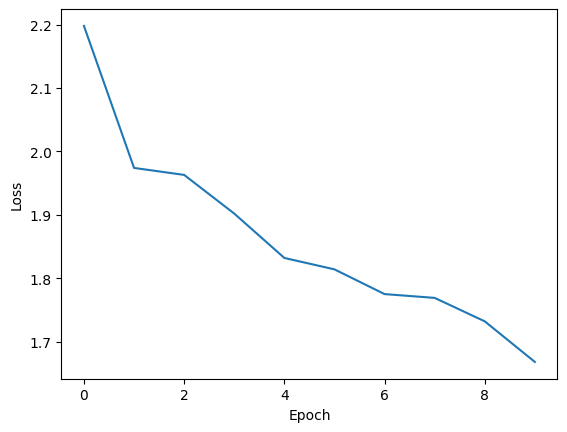

In [15]:
plt.plot(range(epoch),history['loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

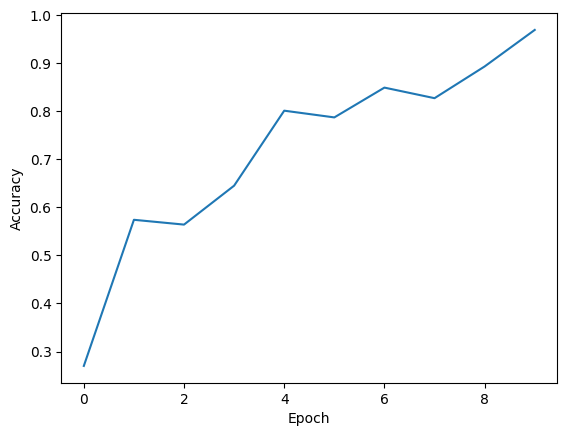

In [16]:
plt.plot(range(epoch), history['accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

# Test

In [17]:
loss, acc, AUC, f1 = test(model,loss_function,dataloader_test)

test set loss: 1.813
test set accuracy: 0.745
test set AUC: 0.923
test set f1-score: 0.745
